In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({
    'font.family': 'Arial'
})
import os
import shutil
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import minmax_scale

pd.set_option('display.max_columns', 500)

import sys
sys.path.append('/Users/bns631/Work/Calcium_imaging/CA_pipeline_2025/napari_scripts')
import matplotlib.colors as mcolors

import plot as plot  # now you can import plot.py
import utils as utils

import pickle


In [2]:
response_df = pd.read_pickle('/Volumes/T9/Ca_data/exp_stimulated/Analysis_new_env/Quantification/Control_vs_NMDA/Tables/Control_vs_NMDA_percentage_responding_per_replicate.pkl')
cluster_df = pd.read_pickle('/Volumes/T9/Ca_data/exp_stimulated/Analysis_new_env/Quantification/Tables/stimulation_to_cluster.pkl')
cell_properties_df = pd.read_pickle('/Volumes/T9/Ca_data/exp_stimulated/Analysis_new_env/Quantification/Tables/cell_properties_baseline_change.pkl')
kcl_df = pd.read_pickle('/Volumes/T9/Ca_data/exp_stimulated/Analysis_new_env/Quantification/Tables/kcl_auc_per_well.pkl')

palette = dict(cell_properties_df[['stimulation', 'colors']].drop_duplicates().values)

# Statistical test for NMDA response

In [3]:
# Test if for equal variance

values_dict = {}
for stim in response_df.stimulation.cat.categories:
    values_dict[stim] = response_df[response_df.stimulation == stim]['proportion_positive_cells'].tolist()

stat, p = stats.levene(*list(values_dict.values()))
print(p)

0.1481618428608406


Control: ShapiroResult(statistic=0.9536569987389655, pvalue=0.5856127585443007)


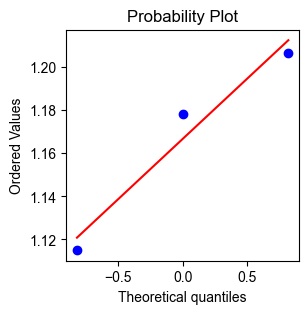

NMDA: ShapiroResult(statistic=0.9751402759947265, pvalue=0.697611294110893)


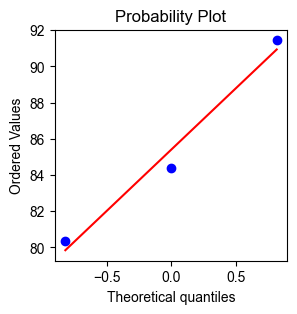

In [4]:
# Test for normality

for key, values in values_dict.items():
    print(f'{key}: {stats.shapiro(values)}')
    
    plt.figure(figsize=(3, 3))
    stats.probplot(values, dist="norm", plot=plt)
    plt.show()
    

In [5]:
# Run t-test
t_stat, p_value = stats.ttest_ind(list(values_dict.values())[0], list(values_dict.values())[1])
p_value

1.306845514126748e-05

In [6]:
# Mean
print('control', round(np.mean(response_df[response_df.stimulation == "Control"].proportion_positive_cells.values),2))
print('NMDA', round(np.mean(response_df[response_df.stimulation == "NMDA"].proportion_positive_cells.values), 2))

control 1.17
NMDA 85.39


In [7]:
# Std
print('control', np.std(response_df[response_df.stimulation == "Control"].proportion_positive_cells.values))
print('NMDA', np.std(response_df[response_df.stimulation == "NMDA"].proportion_positive_cells.values))

control 0.03832125413551235
NMDA 4.586887981848329


# Percentage responding cells barplot

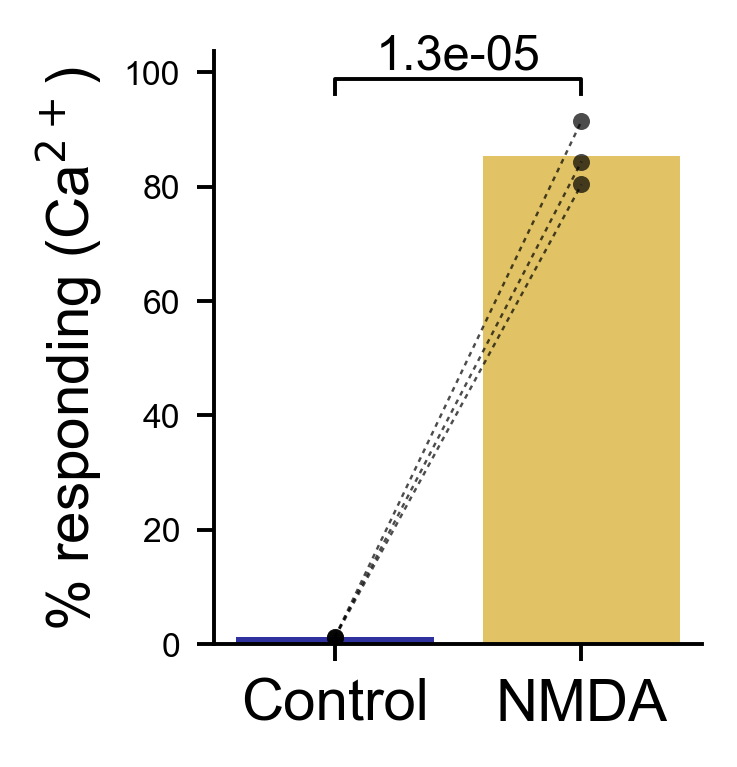

In [11]:
with plt.rc_context({"figure.dpi": 350, "figure.figsize": (1.8, 2.2)}):

    ax = plot.two_conditions_barplot(response_perc_mean_df=response_df, palette = palette, x='stimulation',y='proportion_positive_cells')
    plt.ylabel(r"% responding (Ca$^{2+}$)", fontsize='large')
    
    x1, x2 = 0, 1   
    y, h, col = response_df['proportion_positive_cells'].max() + 4.8, 2.5, 'k'
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
    plt.text((x1+x2)*.5, y+h, round(p_value,6), ha='center', va='bottom', color=col)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)

# Cluster centroid line plot

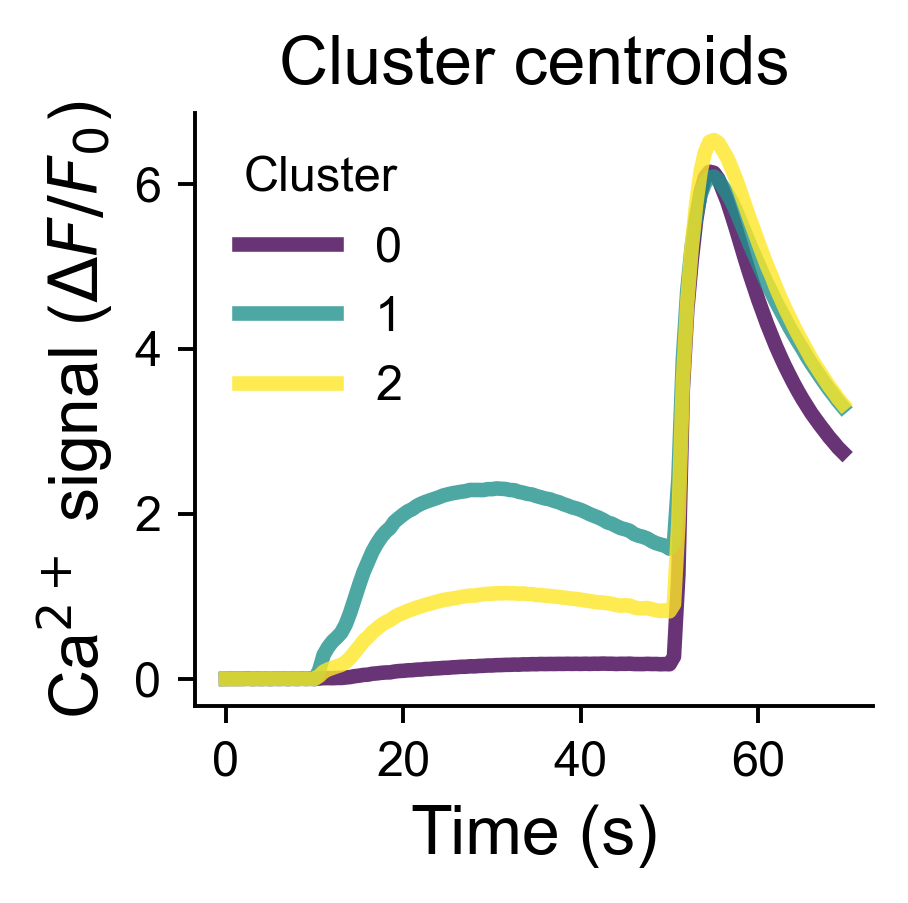

In [12]:
imaging_interval=0.5

cluster_dict, colors_dict = utils.cluster_centroids(cell_properties_df=cell_properties_df)

with plt.rc_context({"figure.dpi": (350), 'figure.figsize':(2.5, 2.2)}):

    ax= plot.cluster_centroids(cluster_dict=cluster_dict,palette=colors_dict, imaging_interval = imaging_interval, alpha=0.8)
    plt.savefig('Fig4/cluster_centroids.pdf',  bbox_inches='tight')
    plt.show()

# Clusters barplot

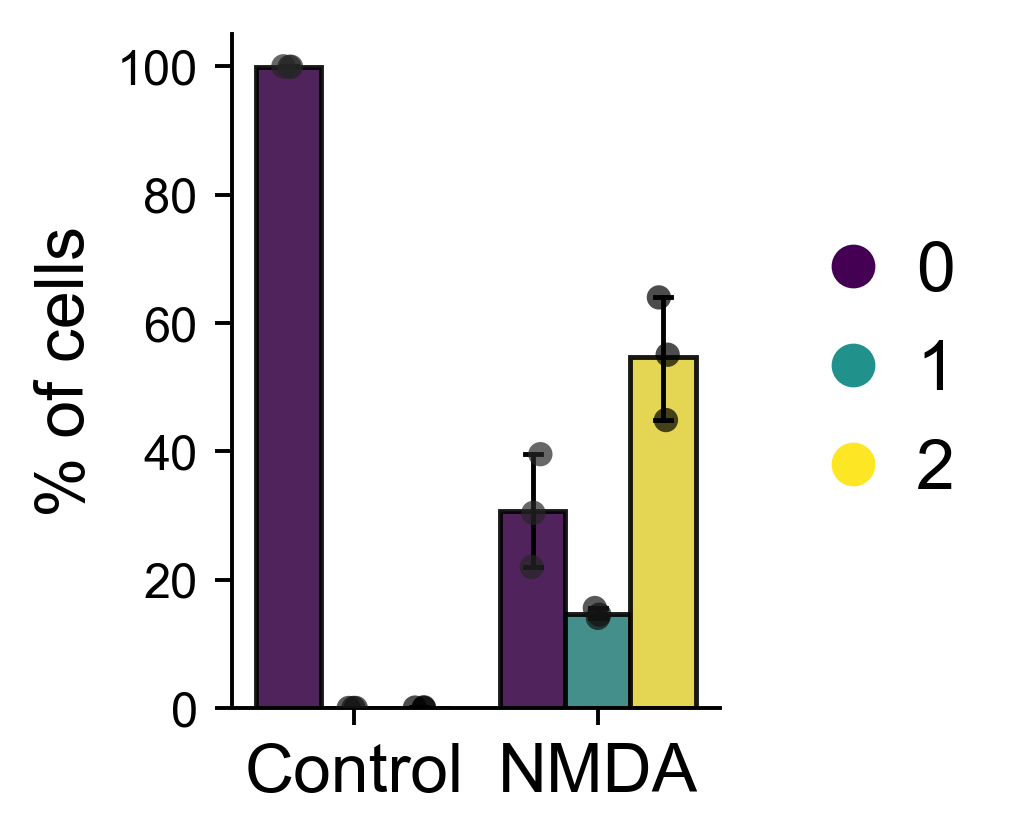

In [13]:
colors_dict = dict(cluster_df[['cluster', 'cluster_color']].drop_duplicates().values.tolist())

with plt.rc_context({"figure.dpi": (350), 'figure.figsize':(1.8, 2.5)}):

    ax_cluster_barplot = plot.all_conditions_barplot(dataframe=cluster_df, palette=colors_dict, ycolumn='proportion',xcolumn='stimulation',hue='cluster', alpha=0.9)
    ax_cluster_barplot.set_ylabel('% of cells', fontsize=14)
    ax_cluster_barplot.set_xlabel('')
    ax_cluster_barplot.set_xlabel('')
    ax_cluster_barplot.tick_params(axis='x',  labelsize=14)
    plt.savefig('Fig4/stimulation_to_cluster_barplot.pdf',  bbox_inches='tight')
    
    
    plt.show()

# ICC analysis

In [14]:
cell_properties_df = pd.read_pickle('/Volumes/T9/Ca_data/exp_stimulated/ICC_analysis/Analysis/Quantification/Tables/cell_properties_baseline_change.pkl')


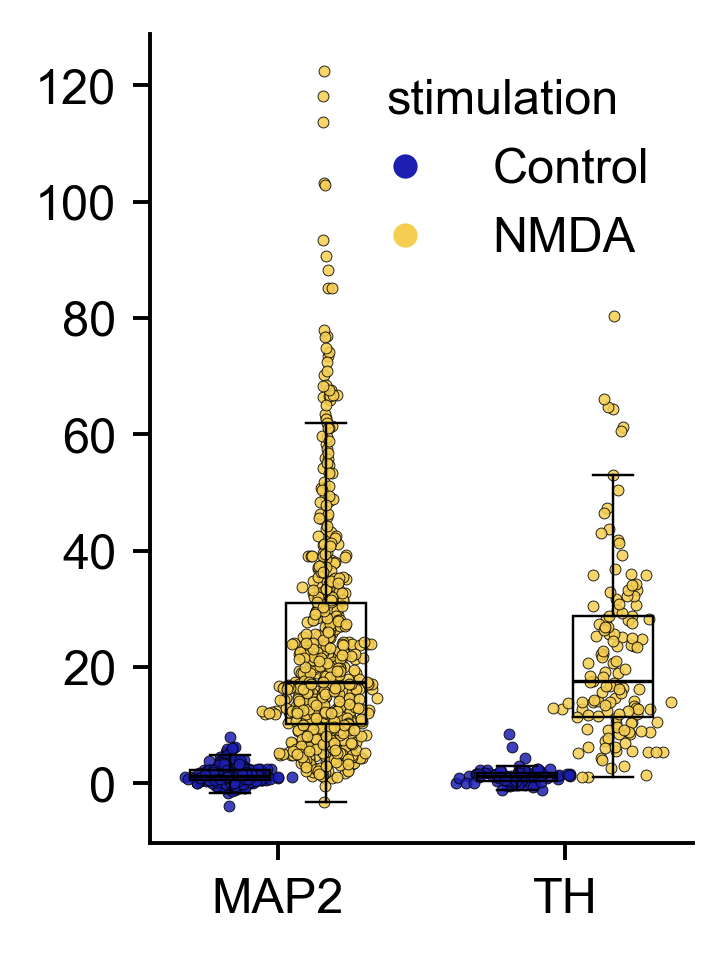

In [17]:
with plt.rc_context({"figure.dpi": (350), 'figure.figsize':(2.0, 3)}):

    ax = plot.beeswarm(cell_properties_df, x="marker", y='AUC',hue='stimulation',  palette=palette, ax=None, separation_between_plots=1.8)

    plt.show()